<a href="https://colab.research.google.com/github/wczubal1/BloombergTask/blob/main/BloombergTaskWitoldCzubala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from statistics import NormalDist

In [4]:
#!pip install scikit-learn
#!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 8.2 MB/s eta 0:00:00


In [2]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
import shap

In [6]:
#Uploading corporate PD datset
data_root = "https://raw.githubusercontent.com/wczubal1/BloombergTask/main/"
df_credit = pd.read_csv(data_root + "df_credit.csv")

In [7]:
#df_credit

In [8]:
#Count of rows with missing values
print (df_credit.isna().any(axis=1).sum())

802


In [9]:
#Removing missing values
df_credit=df_credit.dropna()

In [10]:
np.random.seed(12345);
df_credit.loc[:,'randNumCol'] = np.random.uniform(0, 1, df_credit.shape[0])

In [11]:
df_credit['CreditCombinedPD'].describe()
#df_credit['randNumCol'].describe()

count    1527.000000
mean        0.283032
std         0.493445
min         0.006694
25%         0.074972
50%         0.140495
75%         0.269909
max         5.972882
Name: CreditCombinedPD, dtype: float64

In [12]:
#simulating default
#scaling parameter
k=5
df_credit.loc[:,'Default'] = df_credit['randNumCol']<(k*df_credit['CreditCombinedPD']/100)

In [25]:
print('Number of defaults: ', sum(df_credit['Default']))
#df_credit.loc[df_credit['Default']==True]
df_credit.loc[df_credit['Default']==True,['Default','BusinessSector']].groupby('BusinessSector').sum()

Number of defaults:  27


,Default
BusinessSector,
Applied Resources,1
Banking & Investment Services,4
Cyclical Consumer Products,2
Cyclical Consumer Services,2
Food & Beverages,2
Healthcare Services & Equipment,1
Industrial Goods,2
Real Estate,4
Renewable Energy,1


In [ ]:
#Sector variables
df_credit.groupby('BusinessSector').size()

BusinessSector
Applied Resources                                   17
Automobiles & Auto Parts                            23
Banking & Investment Services                      199
Chemicals                                           32
Consumer Goods Conglomerates                         6
Cyclical Consumer Products                          64
Cyclical Consumer Services                          78
Energy - Fossil Fuels                               67
Financial Technology (Fintech) & Infrastructure      8
Food & Beverages                                    44
Food & Drug Retailing                               12
Healthcare Services & Equipment                    109
Industrial & Commercial Services                    68
Industrial Goods                                   100
Insurance                                           40
Mineral Resources                                   19
Personal & Household Products & Services            19
Pharmaceuticals & Medical Research                

In [ ]:
#Creating dummies for selected sector
dummies=pd.get_dummies(df_credit['BusinessSector'])
#keeping these sectors: Finance due to contagion, Real Estate rates sensitivity and Healthcare and Utilities not sensitive to economic cycle
dummies=dummies[['Banking & Investment Services','Healthcare Services & Equipment','Real Estate','Utilities']]
df_credit=pd.concat([df_credit, dummies],axis=1)

In [ ]:
#Estimation dataset (dropping several columns)
df_estimation= df_credit[df_credit.columns.difference(['Instrument', 'CompanyName', 'BusinessSector', 'CompanyMarketCap', 'CreditCombinedPD', 'randNumCol'])]

In [ ]:
df_estimation.columns

Index(['Banking & Investment Services', 'Default',
       'Healthcare Services & Equipment', 'PriceMomentumT12MVolatility',
       'Real Estate', 'ReturnOnAssets', 'TotalDebttoCommonEquity',
       'Utilities'],
      dtype='object')

In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_estimation.drop(['Default'],axis=1), df_estimation['Default'], test_size=0.25)

# Create the logistic regression model
#model = LogisticRegression()
#Adding regularization penalty and inverse of regularization strength
model = LogisticRegression(penalty='l1', C=12, solver='liblinear',max_iter=1000,class_weight={0: 0.08, 1: 0.92})

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

In [ ]:
# Evaluate the model
accuracy = model.score(X_test, y_test)
print('Accuracy:', accuracy)
accuracy = model.score(X_train, y_train)
print('Accuracy:', accuracy)

Accuracy: 0.9842931937172775
Accuracy: 0.9816593886462882


In [ ]:
model.coef_
#df_estimation.drop(['Default'],axis=1).columns,
pd.DataFrame([df_estimation.drop(['Default'],axis=1).columns,np.transpose(model.coef_)]).T.sort_values(1)

,0,1
1,Healthcare Services & Equipment,[-0.21831461078594736]
5,TotalDebttoCommonEquity,[-0.023888591946563995]
0,Banking & Investment Services,[0.0]
4,ReturnOnAssets,[0.009063717127898451]
2,PriceMomentumT12MVolatility,[0.09731903537631886]
3,Real Estate,[1.4445753007090825]
6,Utilities,[1.982823161283446]


In [ ]:
confusion_matrix(y_test, model.predict(X_test))
confusion_matrix(y_train, model.predict(X_train))

array([[1103,   20],
       [  21,    1]])

In [ ]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      1123
        True       0.05      0.05      0.05        22

    accuracy                           0.96      1145
   macro avg       0.51      0.51      0.51      1145
weighted avg       0.96      0.96      0.96      1145



In [ ]:
final_model = XGBClassifier(objective = "binary:logistic",
                         n_estimators = 99,
                         gamma = 0,
                         importance_type='gain',
                         eval_metric = "mlogloss",
                         max_depth = 5,
                         learning_rate = 0.16701432128403237,
                         max_delta_step=0,
                         booster="gbtree",
                         min_child_weight = 1,
                         scale_pos_weight = None,
                         verbosity = 1)
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.16701432128403237, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
              max_depth=5, max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=99,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

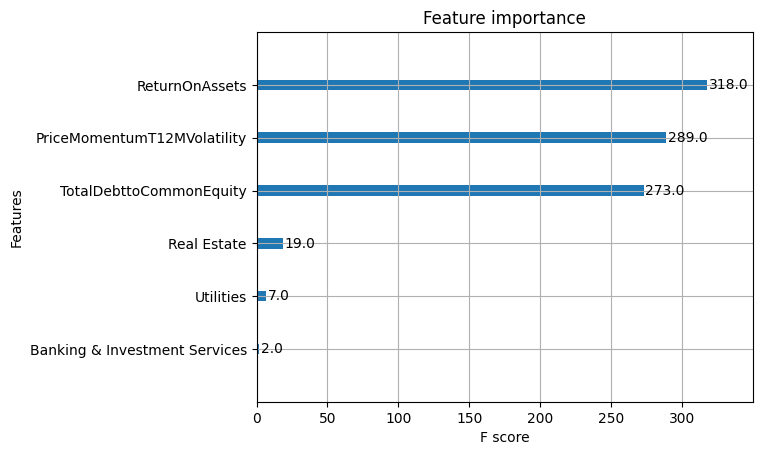

In [ ]:
from xgboost import plot_importance
import matplotlib.pylab as plt
from matplotlib import pyplot
plot_importance(final_model, max_num_features=10)
plt.show()
plt.close()

In [ ]:
confusion_matrix(y_test, final_model.predict(X_test))
confusion_matrix(y_train, final_model.predict(X_train))

array([[1123,    0],
       [   6,   16]])

In [ ]:
# loading
explainer = shap.TreeExplainer(final_model, data=X_train, model_output="probability")
shap_values = explainer.shap_values(X_train)
print(shap_values.shape)

[03:45:01] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


(1145, 7)


In [26]:
#for i in range(0,X_train.shape[0]-1):
#    shap.dependence_plot(X_train.columns[i], shap_values, X_train, interaction_index=None, show=False)
#    plt.xlim(X_train[X_train.columns[i]].quantile(0.01),X_train[X_train.columns[i]].quantile(0.99))
#    plt.show()

In [27]:
#correlation=np.identity(df_estimation.shape[1])

NameError: name 'df_estimation' is not defined